In [2]:
from drn_interactions.io import load_derived_generic
from drn_interactions.transforms import SpikesHandler
from drn_interactions.surrogates import shuffle_spikes
from drn_interactions.transforms.brain_state import StateHandler, RawEEGHandler
from drn_interactions.transforms.brain_state_spikes import (
    align_spikes_to_states_long,
    align_spikes_to_phase_long,
    align_bins_to_states_long,
)
from drn_interactions.responders.brain_state_responders import BSResonders
from drn_interactions.transforms.nbox_transforms import segment_spikes
from drn_interactions.spiketrains.spiketrain_stats import cv_isi_burst
from drn_interactions.config import ExperimentInfo, Config
from drn_interactions.responders.brain_state import (
    SpikeRateResonders,
    PhaseLockResponders,
)
from drn_interactions.spiketrains.neurontype_props import ChiSquarePostHoc

from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import numpy as np
import pandas as pd

sns.set_theme(context="poster", style="ticks")
from drn_interactions.plots.circular import circular_hist

from scipy.signal import detrend
from sklearn.preprocessing import minmax_scale


In [3]:
sns.set_theme(context="paper", style="ticks")

In [4]:
# load meta

eeg_states = load_derived_generic("eeg_states.csv")
session_names = eeg_states.query("quality == 'good'").session_name.unique().tolist()
neuron_types = load_derived_generic("neuron_types.csv")

In [4]:
# load data
spikes_handler = SpikesHandler(
    block="pre",
    t_start=0,
    bin_width=1,
    t_stop=1800,
    session_names=session_names,
)

eeg_handler = RawEEGHandler(
    block="pre",
    t_start=0,
    t_stop=1800,
    session_names=session_names,
)
states_handler = StateHandler(
    quality_to_include=("good", "med"),
    t_start=0,
    t_stop=1800,
    session_names=session_names,
    states_path=Config.derived_data_dir / "eeg_states.csv"
)


df_aligned_phase = align_spikes_to_phase_long(
    spikes_handler=spikes_handler,
    states_handler=states_handler,
    raw_eeg_handler=eeg_handler,
    neuron_types=neuron_types,
).dropna()



# get data by state
df_sw = df_aligned_phase.query("state == 'sw'")
df_act = df_aligned_phase.query("state == 'act'")



# get preferred phase
mod = PhaseLockResponders(round_output=2, fs=19)
df_res_act = mod.prefered_angles(df_act, phase_col="theta_phase_bin")
df_res_sw = mod.prefered_angles(df_sw, phase_col="delta_phase_bin",)
df_prefered_angles = pd.concat([(
        df_res_sw
        .assign(oscillation="delta")
        [["neuron_id", "oscillation", "mean_angle", "var", "p"]]
        ),
        (
            df_res_act
            .assign(oscillation="theta")
            [["neuron_id", "oscillation", "mean_angle", "var", "p"]]
        )
]
)
df_prefered_angles = df_prefered_angles.merge(neuron_types)
display(df_prefered_angles.sample(3))
df_prefered_angles.to_csv(Config.derived_data_dir / "brain_states_phase_responders.csv", index=False)

,neuron_id,oscillation,mean_angle,var,p,neuron_type,session_name,group_name
104,147,delta,0.96,4.82,0.0,SR,ESHOCK_09_LOC1,sham
110,153,delta,-1.69,6.15,0.0,SIR,ESHOCK_09_LOC1,sham
144,180,delta,-3.09,3.75,0.0,SIR,ESHOCK_09_LOC1,sham


In [5]:
df_prefered_angles.assign(sig=lambda x: x.p < 0.05).pivot_table(index="oscillation", columns="neuron_type", values="sig", aggfunc="mean")

neuron_type,FF,SIR,SR
oscillation,,,
delta,0.931034,0.652174,0.718750
theta,0.392857,0.276596,0.206349


In [22]:
def sort_by_nt(df, df_prefered_angles, oscilation):
    idx = (
        df_prefered_angles
        .query(f"oscillation == '{oscilation}'")
        .assign(sig = lambda x: x.p < 0.05)
        .sort_values(["neuron_type", "mean_angle"], ascending=[False, True])
        .neuron_id.tolist()
    )
    df = df[[c for c in idx if c in df.columns]]
    return df

/var/folders/6b/xc7c961d7wgck5t4ltmpjykh0000gn/T/ipykernel_11675/962666675.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["$-\pi$", "$-0.5\pi$", "$0$", "$0.5\pi$", "$\pi$"], rotation=0)


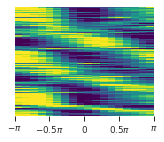

In [29]:
from scipy.ndimage import gaussian_filter1d

f = plt.figure(figsize=(2.5, 2))

ax = f.subplots()
(
    df_sw
    .pivot_table(index="neuron_id", columns="delta_phase_bin", values="spiketimes", aggfunc="sum")
    .fillna(0)
    .transpose()
    .transform(zscore)
    .transform(gaussian_filter1d, sigma=1.5)
    .reset_index()
    .assign(delta_phase_bin=lambda x: x["delta_phase_bin"].round(2))
    .set_index("delta_phase_bin")
    .pipe(sort_by_nt, oscilation="delta", df_prefered_angles=df_prefered_angles)
    .transpose()
    .pipe(sns.heatmap, cmap="viridis", ax=ax, cbar=False, vmin=-1, vmax=1)
)

ax.set_yticks([])
ax.xaxis.set_major_locator(plt.LinearLocator(5))
ax.set_xticklabels(["$-\pi$", "$-0.5\pi$", "$0$", "$0.5\pi$", "$\pi$"], rotation=0)
ax.set_xlabel("")
ax.set_ylabel("")

f.savefig(Config.fig_dir / "bs - phase lock heat delta.png", bbox_inches="tight", dpi=300, transparent=True)

/var/folders/6b/xc7c961d7wgck5t4ltmpjykh0000gn/T/ipykernel_11675/3805754475.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["$-\pi$", "$-0.5\pi$", "$0$", "$0.5\pi$", "$\pi$"], rotation=0)


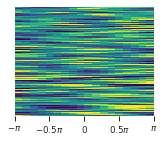

In [30]:
from scipy.ndimage import gaussian_filter1d

f = plt.figure(figsize=(2.5, 2))

ax = f.subplots()
(
    df_act
    .pivot_table(index="neuron_id", columns="theta_phase_bin", values="spiketimes", aggfunc="sum")
    .fillna(0)
    .transpose()
    .transform(zscore)
    .transform(gaussian_filter1d, sigma=1.5)
    .reset_index()
    .assign(delta_phase_bin=lambda x: x["theta_phase_bin"].round(2))
    .set_index("theta_phase_bin")
    .pipe(sort_by_nt, oscilation="delta", df_prefered_angles=df_prefered_angles)
    .transpose()
    .pipe(sns.heatmap, cmap="viridis", ax=ax, cbar=False, vmin=-1, vmax=1)
)

ax.set_yticks([])
ax.xaxis.set_major_locator(plt.LinearLocator(5))
ax.set_xticklabels(["$-\pi$", "$-0.5\pi$", "$0$", "$0.5\pi$", "$\pi$"], rotation=0)
ax.set_xlabel("")
ax.set_ylabel("")

f.savefig(Config.fig_dir / "bs - phase lock heat theta.png", bbox_inches="tight", dpi=300, transparent=True)

In [18]:
df_prefered_angles

,neuron_id,oscillation,mean_angle,var,p,neuron_type,session_name,group_name
0,81,delta,1.25,8.41,0.37,SIR,ESHOCK_07_LOC1,sham
1,81,theta,2.03,7.55,0.54,SIR,ESHOCK_07_LOC1,sham
2,82,delta,1.06,6.60,0.51,SIR,ESHOCK_07_LOC1,sham
3,82,theta,-1.67,10.46,0.99,SIR,ESHOCK_07_LOC1,sham
4,84,delta,0.44,5.05,0.00,SR,ESHOCK_07_LOC1,sham
...,...,...,...,...,...,...,...,...
272,2590,delta,2.69,4.22,0.00,SIR,acute_12,acute_saline
273,2590,theta,2.16,6.66,0.22,SIR,acute_12,acute_saline
274,2522,theta,-2.09,4.89,0.99,SR,acute_12,acute_saline
275,2523,theta,-2.82,1.39,0.00,SIR,acute_12,acute_saline


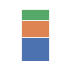

In [20]:
def stacked_bar_single(oscillation, ax):
    df_prefered_angles.query("oscillation == @oscillation")["neuron_type"].value_counts().to_frame().T.plot(kind="bar", stacked=True, ax=ax, legend=False)
    ax.axis("off")
    return ax

f = plt.figure(figsize=(1, 1))
ax = f.subplots()

stacked_bar_single(oscillation="delta", ax=ax)
f.savefig(Config.fig_dir / "bs - phase lock heatmap key delta.png",  transparent=True)


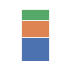

In [21]:
f = plt.figure(figsize=(1, 1))
ax = f.subplots()


stacked_bar_single(oscillation="theta", ax=ax)
f.savefig(Config.fig_dir / "bs - phase lock heatmap key theta.png",  transparent=True)

In [6]:
eeg_handler.raw_eeg_df.dropna()

,voltage,session_name,signal_name,timepoint_s,group_name,delta,theta,delta_phase,theta_phase,delta_phase_deg,theta_phase_deg,delta_phase_bin,theta_phase_bin
3927164,-145.015816,ESHOCK_07_LOC1,eeg_occ,7.508,sham,-174.355419,64.986890,3.086721,0.093226,176.856109,5.341457,2.792527,0.000000
3927165,-153.797161,ESHOCK_07_LOC1,eeg_occ,7.512,sham,-170.996994,62.395648,2.977783,0.210381,170.614413,12.053962,2.792527,0.000000
3927166,-153.797160,ESHOCK_07_LOC1,eeg_occ,7.516,sham,-168.109866,58.994308,3.000133,0.325538,171.894960,18.651978,2.792527,0.000000
3927167,-153.797159,ESHOCK_07_LOC1,eeg_occ,7.520,sham,-165.695469,54.930163,2.973229,0.438717,170.353445,25.136636,2.792527,0.349066
3927168,-127.989779,ESHOCK_07_LOC1,eeg_occ,7.524,sham,-163.750552,50.350869,2.990013,0.549600,171.315102,31.489763,2.792527,0.349066
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11419605,36.863493,acute_12,eeg_occ,1792.480,acute_saline,-66.369262,67.126103,2.864367,0.327701,164.116151,18.775859,2.792527,0.000000
11419606,12.230119,acute_12,eeg_occ,1792.484,acute_saline,-79.437141,65.726954,2.908911,0.453636,166.668325,25.991429,2.792527,0.349066
11419607,12.230116,acute_12,eeg_occ,1792.488,acute_saline,-92.669065,62.966283,-2.952404,0.579579,-169.160298,33.207459,-3.141593,0.349066
11419608,12.230114,acute_12,eeg_occ,1792.492,acute_saline,-105.970611,58.827539,-2.941280,0.705895,-168.522909,40.444780,-3.141593,0.698132


In [8]:
# Consistency


def get_responders(t_start=0, t_stop=1800):
    # load data
    spikes_handler = SpikesHandler(
        block="pre",
        t_start=t_start,
        bin_width=1,
        t_stop=t_stop,
        session_names=session_names,
    )

    eeg_handler = RawEEGHandler(
        block="pre",
        t_start=t_start,
        t_stop=t_stop,
        session_names=session_names,
    )
    states_handler = StateHandler(
        quality_to_include=("good",),
        t_start=t_start,
        t_stop=t_stop,
        session_names=session_names,
        states_path=Config.derived_data_dir / "eeg_states.csv"
    )


    df_aligned_phase = align_spikes_to_phase_long(
        spikes_handler=spikes_handler,
        states_handler=states_handler,
        raw_eeg_handler=eeg_handler,
        neuron_types=neuron_types,
    ).dropna()

    # get data by state
    df_sw = df_aligned_phase.query("state == 'sw'")
    df_act = df_aligned_phase.query("state == 'act'")



    # get preferred phase
    mod = PhaseLockResponders(round_output=2, fs=19)
    df_res_act = mod.prefered_angles(df_act, phase_col="theta_phase_bin")
    df_res_sw = mod.prefered_angles(df_sw, phase_col="delta_phase_bin",)
    df_prefered_angles = pd.concat([(
            df_res_sw
            .assign(oscillation="delta")
            [["neuron_id", "oscillation", "mean_angle", "var", "p"]]
            ),
            (
                df_res_act
                .assign(oscillation="theta")
                [["neuron_id", "oscillation", "mean_angle", "var", "p"]]
            )
    ]
    )
    df_prefered_angles = df_prefered_angles.merge(neuron_types)
    return df_prefered_angles


In [10]:
res_first_half = get_responders(t_start=0, t_stop=900)
res_second_half = get_responders(t_start=900, t_stop=1800)

In [13]:
from pingouin.circular import circ_corrcc

def get_corr(df1, df2, oscillation):
    df1 = df1.query("oscillation == @oscillation and p < 0.05").set_index("neuron_id")
    df2 = df2.query("oscillation == @oscillation and p < 0.05").set_index("neuron_id")
    df =  df1[["mean_angle"]].join(df2[["mean_angle"]], lsuffix="_1", rsuffix="_2")
    r, p = circ_corrcc(df["mean_angle_1"], df["mean_angle_2"])
    return r, p


get_corr(res_first_half, res_second_half, oscillation="delta")

(0.787936697911071, 2.9163039011292843e-06)

In [14]:


get_corr(res_first_half, res_second_half, oscillation="theta")

(0.8054179325482127, 0.005129715191136384)